# Бэггинг и случайный лес

In [1]:
%pylab inline
from sklearn import ensemble, model_selection, metrics 

import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных
Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).

In [2]:
digits = load_digits()
X = digits.data
y = digits.target
cv = 10

In [3]:
def print_to_file(estimator, name):
    mean = cross_val_score(estimator, X, y, cv=cv).mean()
    print(mean)
    with open(name, "w") as file:
        file.write(str(mean))

## Обучение
Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью вы можете натолкнуться на случай, когда полученное вами качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае попробуйте перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение. Если это не помогает, то где-то была допущена ошибка.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs, но будьте осторожны: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.

### DecisionTreeClassifier
Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.

In [4]:
tree = DecisionTreeClassifier()
tree.fit(X,y)
print_to_file(tree, '1.txt')

0.8271070414071703


### BaggingClassifier
Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

Качество классификации новой модели - ответ в пункте 2. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

In [5]:
bagging = BaggingClassifier(n_estimators = 100)
bagging.fit(X,y)
print_to_file(bagging, '2.txt')

0.9249155367857638


### BaggingClassifier с ограниченным количеством признаков
Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt d$ случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [6]:
bagging = BaggingClassifier(n_estimators = 100, max_features = int(np.sqrt(X.shape[1])))
bagging.fit(X,y)
print_to_file(bagging, '3.txt')

0.9231582586148857


### Случайный лес своими руками
Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt d $ признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4.

In [7]:
tree = DecisionTreeClassifier(max_features=int(np.sqrt(X.shape[1])))
bagging = BaggingClassifier(base_estimator=tree, n_estimators=100)
print_to_file(bagging, '4.txt')

0.9527495719145957


In [8]:
rand = RandomForestClassifier(n_estimators = 100, max_features=int(np.sqrt(X.shape[1])))
tree.fit(X,y)
print_to_file(rand, 'deleteme.txt')

0.9555369165640467


При сравнении с случайного леса на основе BaggingClassifier и DecisionTreeClassifier с RandomForestClassifier было обнаружено, что качество приблизительно равно друг другу.

### Ответы на вопросы

* ~~Случайный лес сильно переобучается с ростом количества деревьев~~
* При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев
* С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется
* При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.
* ~~При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.~~
* ~~При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается~~
* При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга). 

In [9]:
def plot_error(X, y, new_params, title):
    X_plot = []
    y_plot = []
    for i in np.arange(1, 61, 5):
        params = {'n_estimators': i, 'max_features': i, 'max_depth': i}
        for key, value in new_params.items():
            params[key] = new_params[key]
        rand = RandomForestClassifier(**params)
        tree.fit(X,y)
        X_plot.append(i)
        y_plot.append(cross_val_score(rand, X, y, cv=cv).mean())
    plt.plot(X_plot, y_plot)
    plt.title(title)

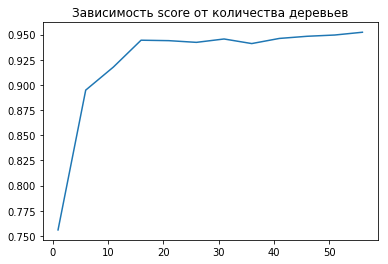

In [10]:
const_params = {'max_features':int(np.sqrt(X.shape[1])), 'max_depth': None}
plot_error(X,y, const_params, 'Зависимость score от количества деревьев')

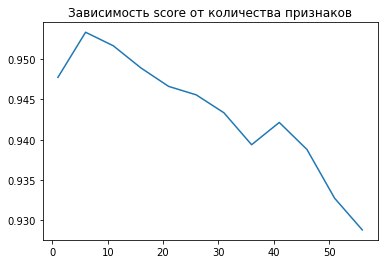

In [11]:
const_params = {'n_estimators':100, 'max_depth': None}
plot_error(X,y, const_params, 'Зависимость score от количества признаков')

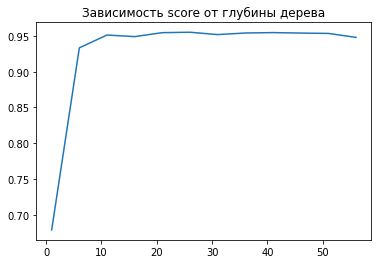

In [12]:
const_params = {'n_estimators':100, 'max_features':int(np.sqrt(X.shape[1]))}
plot_error(X,y, const_params, 'Зависимость score от глубины дерева')

In [13]:
file = open('5.txt', "w")
file.write('2 3 4 7')
file.close()